In [1]:
import pandas as pd
import json
import numpy as np
from os import listdir
import time 
import random
import requests
import json
from datetime import datetime
from pyecharts import Bar, Line, Overlap, Map, Geo,WordCloud, Pie
import re
import matplotlib.pyplot as plt
from collections import Counter
import jieba
from snownlp import SnowNLP
import jieba.analyse
import matplotlib as mpl
import seaborn as sns



In [2]:
def time2stamp(cmnttime):
    cmnttime = datetime.strptime(cmnttime, '%Y-%m-%d %H:%M:%S') 
    stamp = int(datetime.timestamp(cmnttime))
    return stamp

In [3]:
df = pd.read_csv('data.csv')
df.columns

Index(['IPs', 'againsts', 'buildLevels', 'commentIds', 'contents',
       'createTimes', 'favCounts', 'isDels', 'is_anonymous', 'shareCounts',
       'siteNames', 'sources', 'user_IDs', 'user_locations', 'votes'],
      dtype='object')

In [4]:
df['stamp'] = df['createTimes'].apply(time2stamp)
df['time_mdh'] = df['createTimes'].apply(lambda x:x.split(':')[0][5:])
count_per_hour = df.groupby('time_mdh').count()['commentIds'].to_frame()  # 每小时评论数数据

df

,IPs,againsts,buildLevels,commentIds,contents,createTimes,favCounts,isDels,is_anonymous,shareCounts,siteNames,sources,user_IDs,user_locations,votes,stamp,time_mdh
0,117.136.*.*,0,6,331532417,劫匪说：没事，俺也有,2018-11-19 10:15:38,0,False,True,0,网易,ph,0,安徽省,0,1542593738,11-19 10
1,113.102.*.*,1,2,330898778,有些个妇人，以为自个本事大，有魄力，动不动还瞧不起男人，不听劝告，自以为是，自以为有个性，有...,2018-11-18 12:17:22,0,False,False,0,网易,wb,989789,广东省深圳,20,1542514642,11-18 12
2,116.5.*.*,0,1,331615846,广西人[喷水],2018-11-19 12:19:03,0,False,False,0,网易,ph,107368171,广东省佛山市,1,1542601143,11-19 12
3,222.74.*.*,1,1,330656583,现在每个公园，景区，长期都有那些跑路的，离家出走的流浪汉，我一大男人经常跑步都能感受到那鬼鬼...,2018-11-18 00:48:04,12,False,False,0,网易,ph,125943715,广东省清远市,4417,1542473284,11-18 00
4,27.38.*.*,0,7,331810882,你是萨比[大笑][大笑][大笑],2018-11-19 16:53:28,0,False,False,0,网易,ph,504719,广东省深圳市,0,1542617608,11-19 16
5,122.237.*.*,0,6,330829609,萨比的是你,2018-11-18 10:36:41,0,False,False,0,网易,ph,17451673,浙江省绍兴,1,1542508601,11-18 10
6,117.161.*.*,0,5,333625983,你说全世界最安全的国家是哪？中国多大多少人？美国，俄罗斯，多少人？犯罪率多少？,2018-11-21 21:40:19,0,False,True,0,网易,ph,0,辽宁省沈阳市,0,1542807619,11-21 21
7,14.24.*.*,0,1,330799108,说好的国内安全呢，这大嘴巴子抽的舒服不,2018-11-18 09:45:35,0,False,False,0,网易,ph,9248336,广东省广州市,2,1542505535,11-18 09
8,112.10.*.*,0,7,331616219,你胡搅蛮缠的毫无逻辑，事实是嫌犯无缘无故杀害学成回国的女留学生，你自己说他够不够野蛮？你还拿...,2018-11-19 12:19:24,0,False,True,0,网易,ph,0,浙江省杭州,0,1542601164,11-19 12
9,60.178.*.*,3,2,330659977,18岁时独自逛过西湖灵隐那边景区，然后迷路了，晚上七八点才摸回家，还是上了一辆载有好几个男人...,2018-11-18 01:04:01,1,False,True,0,网易,ph,0,浙江省宁波,1035,1542474241,11-18 01


## 每小时评论数

In [6]:
bar = Bar("每小时评论数")
bar.add("",count_per_hour.index, count_per_hour['commentIds'],
        is_label_show = True ,
        xaxis_rotate = -90, yaxis_interval = 200,yaxis_max = 400,
       is_xaxis_show = True)
bar.render('bar_每小时评论数.html')

line = Line("每小时评论数")
line.add("折线图", count_per_hour.index, count_per_hour['commentIds'],line_opacity=1,line_type='dotted',)
line.render('line_每小时评论数.html')

overlap = Overlap()
overlap.add(bar)
overlap.add(line, is_add_yaxis=True, yaxis_index=1)
overlap.render('overlap_每小时评论数.html') # 使用 render() 渲染生成 .html 文件

## 省份统计

In [7]:
def get_pro(area):
    prolist = ['北京', '天津', '上海', '重庆', '河北', '山西', '辽宁', 
               '吉林', '江苏', '浙江', '安徽', '福建', '江西', '山东', 
               '河南', '湖北', '湖南', '广东', '海南', '四川', '贵州', 
               '云南', '陕西', '甘肃', '青海', '台湾', '广西', '西藏', 
               '宁夏', '新疆', '香港', '澳门', '内蒙古', '黑龙江']
    for pro in prolist:
        if pro in area:
            return pro
    return "海外"
df['pro'] = df['user_locations'].apply(get_pro)
province_count = df.groupby('pro')['pro'].count().sort_values(ascending=False)

bar = Bar("省份分布")
bar.add("省份", province_count.index, province_count.values,
        is_label_show=True, xaxis_interval = 0, xaxis_rotate = 60)
bar.render('bar_省份分布.html')

mapp = Map("省份分布情况", width=1000, height=600)
#mapp.use_theme("macarons") # 换主题
mapp.add("", province_count.index, province_count.values, maptype='china', is_visualmap=True,
         visual_range=[0, 480], is_map_symbol_show=False, visual_text_color='#000', is_label_show=True)
mapp.render('map_省份分布.html')


## 城市统计

In [8]:
prolist = '北京市，天津市，上海市，重庆市，河北省，山西省，辽宁省，吉林省，江苏省，浙江省，安徽省，福建省，\
江西省，山东省，河南省，湖北省，湖南省，广东省，海南省，四川省，贵州省，云南省，陕西省，甘肃省，\
青海省，台湾省，广西，西藏，宁夏，新疆，香港，澳门，内蒙古，黑龙江省'
prolist = prolist.replace('市', '').replace('省', '').split('，')
unchinas = list(set(df[df['pro'] == '海外']['user_locations']))

prolist = ['北京', '天津', '上海', '重庆', '河北', '山西', '辽宁', 
               '吉林', '江苏', '浙江', '安徽', '福建', '江西', '山东', 
               '河南', '湖北', '湖南', '广东', '海南', '四川', '贵州', 
               '云南', '陕西', '甘肃', '青海', '台湾', '广西', '西藏', 
               '宁夏', '新疆', '香港', '澳门', '内蒙古', '黑龙江']

df['area'] = df['user_locations'].apply(lambda x : x.replace('省','').replace('市',''))

for i in range(len(df)):
    if df.loc[i,'area'] in unchinas:
        df.loc[i,'city'] = 'unknow'
    for pro in prolist:
        if pro in df.loc[i,'area'] and pro not in ['北京', '天津', '上海', '重庆','香港','澳门'] and '自治区' not in df.loc[i,'area']:
            df.loc[i,'city'] = df.loc[i,'area'][len(pro):]
        if pro in df.loc[i,'area'] and pro not in ['北京', '天津', '上海', '重庆','香港','澳门'] and '自治区'  in df.loc[i,'area']:
            ind = df.loc[i,'area'].find('自治区') + len('自治区') 
            df.loc[i,'city'] = df.loc[i,'area'][ind:]
        
        if pro in df.loc[i,'area'] and pro  in ['北京', '天津', '上海', '重庆','香港','澳门']:
             df.loc[i,'city'] = pro
                
df['city'] = df['city'].apply(lambda x: 'unknow' if x == '' else x)



In [9]:
city_count = df.groupby('city')['city'].count().sort_values(ascending=False)
city_name = list(city_count.index)
city_values = city_count.values

bar = Bar("城市分布")
bar.add("城市", city_count.index[:30], city_count.values[:30],is_label_show=True,xaxis_interval=0,xaxis_rotate=-45)
bar.render('bar_城市分布.html')

city_data = list(zip(city_count.index, city_count.values))

geo = Geo("城市分布情况", "data from SinaNews", title_color="#fff",
            width=900,height=700,background_color='#404a59')

working_city = []
working_value = []
attrs, values = geo.cast(city_data)
for attr, value in zip(attrs, values):
    name_list = ['上海']
    name_list.append(attr)
    
    value_list = [169]
    value_list.append(value)
    try:
        geo.add("城市分布情况", name_list, value_list, visual_range=[0, 360], visual_text_color="#fff",
            symbol_size=10, is_visualmap=True)
        working_city.append(attr)
        working_value.append(value)
    except:
        pass
    
geo.add("城市分布情况", working_city, working_value, visual_range=[0, 180], visual_text_color="#fff",
            symbol_size=10, is_visualmap=True)

geo.render('geo_城市分布情况.html')

## 通过正则提取表情emojo

In [10]:
def get_emoji(content):
    pattern =re.compile(u"\[[a-zA-Z\u4e00-\u9fa5]+\]")
    result=re.findall(pattern,content)
    return result
df['emojis_list'] = df['contents'].apply(get_emoji)

emojis = df['emojis_list'].values.tolist()
emojis_list = sum(emojis, [])
emojis_set = list(set(emojis_list))
counter = Counter(emojis_list)
y_emojis, x_counts = zip(*counter.most_common())

bar = Bar("表情使用情况")
bar.add("", y_emojis[:20], x_counts[:20], 
        is_stack = True, is_label_show = True,
        xaxis_interval = 0, xaxis_rotate = 45, xaxis_margin = 8)
bar.render('bar_表情使用情况.html')

## NLTK 分布图谱

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/5v/43zb1wt95qx954nbz6z9tx4m0000gn/T/jieba.cache
DEBUG:jieba:Dumping model to file cache /var/folders/5v/43zb1wt95qx954nbz6z9tx4m0000gn/T/jieba.cache
Loading model cost 1.591 seconds.
DEBUG:jieba:Loading model cost 1.591 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


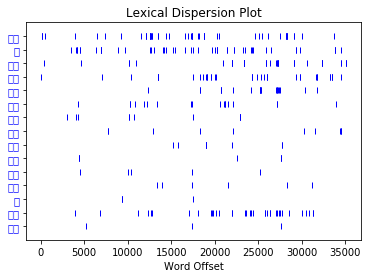

In [11]:
cmnts_list = df['contents'].values.tolist()
cmnts = ' '.join(cmnts_list)
emoji_drop = []
for emojis in y_emojis:
    emoji = emojis[1:-1] # 去掉括号
    jieba.add_word(emoji) # 读者可将上一行注释掉，看看分词结果
    emoji_drop.append(emoji) # 将去掉括号后的emoji单独保存
words = list(jieba.cut(cmnts))

%matplotlib inline
import nltk
from nltk.draw.dispersion import dispersion_plot

plt.rcParams['font.sans-serif'] = ['SimHei']
ntext = nltk.Text(words)
ntext.dispersion_plot(emoji_drop[:15])

In [12]:
def count_laugh(content):
    if '[大笑]' in content:
        finder = re.findall("大笑", content)
        return len(finder)
    else:
        return 0
df['number_laugh'] = df['contents'].apply(count_laugh)
df_laugh = df.sort_values(by ='number_laugh' , ascending = False)
df_laugh[['contents','isDels','is_anonymous','votes','againsts','number_laugh']]

,contents,isDels,is_anonymous,votes,againsts,number_laugh
981,治安最好的国家，怕个毛[大笑][大笑][大笑][大笑],False,True,0,0,4
553,几个农民工和乞丐义士前后夹击你[大笑][大笑][狗]，当然他们也不杀人，轮个三五日让你受精后...,False,False,0,0,4
1673,那是你长得安全[大笑][大笑][大笑],False,False,1,0,3
4,你是萨比[大笑][大笑][大笑],False,False,0,0,3
520,抠脚大汉真是都齐聚一堂了！[大笑][大笑][大笑]哪天有空来编辑部签约；写小说。不然浪费大好青春,False,False,0,0,3
1664,不錯哦！請禁止廣西人，[大笑][大笑],False,False,0,0,2
882,[大笑][大笑],False,False,1,0,2
1717,签定完毕，这枯灯纯沙币一个，你看它回复的和每层楼上的都不怎么相关，有点歪脚部发言人的感觉，村...,False,True,0,0,2
562,二口楼估计是长的丑，哈哈哈[大笑][大笑],False,False,0,0,2
547,桂林人就是没有大城市的人品好，周立齐老师你还收徒弟么？[大笑][大笑]90秒修电车的技术不能...,False,False,0,0,2


## 情感分析

In [13]:
def sentiment(content):
    s = SnowNLP(content)
    return s.sentiments

df['sentiment'] = df.contents.apply(sentiment)

df_sent = df[['contents', 'sentiment','votes','againsts']]
df_sent.sort_values(by=['sentiment'],ascending=False).to_csv('emotion_analy.csv', index = None)
df_sent.sort_values(by=['sentiment'],ascending=False).head()

,contents,sentiment,votes,againsts
136,制约，才是人类第一普世价值。（制约人性之中“私”与“恶”的释放与放大的自由）<br><br>...,1.0,1,0
639,全球化时代的中国人应读 新四大名著（外国人上榜一本）：<br><br>1，路遥《平凡的世界...,1.0,1,0
1329,人这一生就是为欲望而活，同时也在和各种欲望做抗争。每个人由于自身条件的不同需要面对克服和释放...,1.0,19,0
1819,缺乏良好的教育，从而导致步入社会后的挫败感而走向极端，我想这类人不在少数！加之现在的经济形势...,1.0,2,0
1802,他说的也没错。对家庭来说，嫌疑人是散养长大的，有什么吃什么，不死就能长大。被害人是全家付出很...,1.0,21,0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


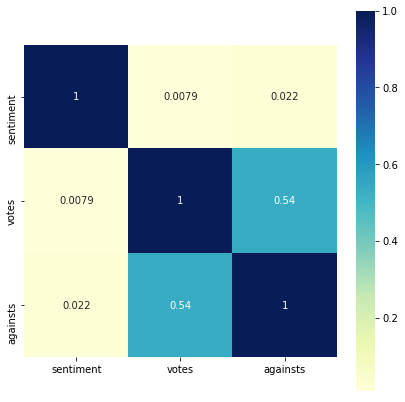

In [14]:
fig, ax = plt.subplots(figsize = (7,7))
corr_mat = df_sent.corr()
sns.heatmap(corr_mat ,cmap="YlGnBu", xticklabels= True, yticklabels= True, square=True, annot=True)


## 基于 TF-IDF 算法的关键词抽取

In [15]:
all_content = df['contents'].values.tolist()
extract_tags = "  ".join(jieba.analyse.extract_tags(' '.join(all_content), topK=500, withWeight=False, allowPOS=('ns', 'n')))
print(extract_tags)

广西  扫黄  前科  杀人  人渣  强奸  社会  浙江  地方  坏人  垃圾  女孩子  一楼  女生  治安  女孩  广东  女人  人格  杭州  二楼  女性  浙大  强奸犯  警方  光棍  流动人口  小心  地域  男人  单身  犯罪率  中国  罪犯  败类  无辜  心痛  广西省  好人  外地人  滴滴  孩子  公园  国家  东莞  笨蛋  人性  父母  凶手  时候  东北  问题  嫌疑人  事情  大学生  景区  云南  跑步  案件  网易  结果  外来人口  人家  屌丝  杀人案  思维  新闻  人员  网友  命案  理智  渣子  美国  畜生  全州  变态  火星  作案  司机  合法  畜牲  人才  法律  受害者  逝者  悲剧  家庭  坏事  干嘛  感觉  祸害  建议  大家  西湖  外省  选側  男女比例  全国  色狼  老师  世界  卧槽  本地人  爬山  手机  案子  学会  运气  同学  劫色  害人  逻辑  玩意  红灯区  嫌犯  天堂  姑娘  女子  经济  智障  毕业  有点  文化  顺风  脑子  大脑  四川  高材生  男女  外地  老表  概率  留学生  破案率  基本  朋友  意思  人民  广西壮族自治区  女同胞  极端  意识  神速  城市  学学  原因  年轻人  输出地  外来人员  惯犯  个人  被害人  女儿  效率  方式  米国  蝴蓝  芬子  东西  歹徒  胆子  流浪汉  后遗症  英国  死者  飞车  单身女人  心理  杀人者  犯事  网络  邪念  回家  名字  良家妇女  长大  河池  媒体  父母心  盘子  人生  动物  评论  职业  摄像头  户籍制度  事件  事儿  网警  精虫  印度  大白天  素质  动机  身材  智商  学成回国  渠道  外国  出租车  犯罪分子  恶魔  电动车  大神  无法  无知者  理由  人口  禽兽  人犯  现实  化学  民工  男生  情况  后果  少性  廣西  廣東  撸串  老铁  人脸识别  事会  上脑  废柴  地区  死亡率  危害  保护意识  组队  电瓶车  人为  县城  精英  恶性  学生  

In [16]:
segment = []
for line in all_content:
    try:
        segs = jieba.lcut(line)
        for seg in segs:
            if len(seg)>1 and seg != '\r\n':
                segment.append(seg)
    except:
        print(line)
        continue
# 去停用词
words_df = pd.DataFrame({"segment": segment})

words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数": np.size})
words_stat = words_stat.reset_index().sort_values(by=["计数"], ascending=False)
words_stat.head(5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,segment,计数
109,一个,178
2311,广西,143
81,br,116
2177,就是,113
358,不是,107


In [17]:
wordcloud = WordCloud(width=800, height=520)
wordcloud.add("评论词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud.render('wc_评论词云.html')

## 删帖情况

In [18]:
isDels_count = df.groupby('isDels')['isDels'].count()
pie = Pie('被发布者删去的评论占比',title_pos='center')
pie.add('只有0.4%的评论被删', isDels_count.index , isDels_count.values , is_label_show = True,
       lrosetype = 'radius', radius=[40, 75], rosetype="area",is_legend_show = True ,
       is_random=True, legend_orient="vertical")
pie.render('pie_被发布者删去的评论占比.html')

## 匿名情况

In [19]:
is_anonymous_count = df.groupby('is_anonymous')['isDels'].count()
pie = Pie('匿名评论占比',title_pos='center')
pie.add('', is_anonymous_count.index , is_anonymous_count.values , is_label_show = True,
       lrosetype = 'radius' ,is_legend_show = True ,
       is_random=True, legend_orient="vertical")
pie.render('pie_匿名评论占比.html')